# mount google drive to my personal drive so i can store audio tracks between sessions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

DRIVE_BASE = '/content/drive/MyDrive/CQTNet/crawl_data/CQTNet_data'


Mounted at /content/drive


#Create CQT from Audio Clip (NEW FROM HERE)

In [ ]:
!pip install librosa
!pip install tqdm

In [ ]:
import librosa
import numpy as np
import os
from tqdm import tqdm

In [ ]:
# train_dir = os.path.join(DRIVE_BASE, 'train')
# test_dir = os.path.join(DRIVE_BASE, 'test')
# out_dir = os.path.join(DRIVE_BASE, 'youtube_cqt_npy')
# os.makedirs(out_dir, exist_ok=True)

# def CQT(args):
#     in_path, out_path = args
#     try:
#         data, sr = librosa.load(in_path)
#         if len(data)<1000:
#             return
#         cqt = np.abs(librosa.cqt(y=data, sr=sr))
#         mean_size = 20
#         height, length = cqt.shape
#         new_cqt = np.zeros((height,int(length/mean_size)),dtype=np.float64)
#         for i in range(int(length/mean_size)):
#             new_cqt[:,i] = cqt[:,i*mean_size:(i+1)*mean_size].mean(axis=1)
#         np.save(out_path, new_cqt)
#     except Exception as e: # Catch and print the specific exception
#         print(f'Error processing {in_path}: {e}')


# params = []
# for data_dir in [train_dir, test_dir]:
#     for ii, (root, dirs, files) in tqdm(enumerate(os.walk(data_dir))):
#         if len(files):
#             for file in files:
#                 in_path = os.path.join(root,file)
#                 out_path = os.path.join(out_dir, file.split('.')[0] + '.npy')
#                 params.append((in_path, out_path))

# for p in tqdm(params):
#     CQT(p)

### removed 0_138.m4a because it was not openable
### 191 train 40 test CQT generated

#Augment CQT Data

In [ ]:
# import os

# train_dir = os.path.join(DRIVE_BASE, 'train')
# test_dir = os.path.join(DRIVE_BASE, 'test')

# train_output_path = os.path.join(DRIVE_BASE, 'train_tracks.txt')
# test_output_path = os.path.join(DRIVE_BASE, 'test_tracks.txt')

# train_tracks = []
# for root, dirs, files in os.walk(train_dir):
#     for file in files:
#         train_tracks.append(file.split('.')[0])

# test_tracks = []
# for root, dirs, files in os.walk(test_dir):
#     for file in files:
#         test_tracks.append(file.split('.')[0])

# with open(train_output_path, 'w') as f:
#     for track_path in train_tracks:
#         f.write(track_path + '\n')

# with open(test_output_path, 'w') as f:
#     for track_path in test_tracks:
#         f.write(track_path + '\n')

# print(f"Training track list saved to {train_output_path}")
# print(f"Test track list saved to {test_output_path}")

In [ ]:
from torchvision import transforms
import torch, torch.utils
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import PIL

def cut_data(data, out_length):
    if out_length is not None:
        if data.shape[0] > out_length:
            max_offset = data.shape[0] - out_length
            offset = np.random.randint(max_offset)
            data = data[offset:(out_length+offset),:]
        else:
            offset = out_length - data.shape[0]
            data = np.pad(data, ((0,offset),(0,0)), "constant")
    if data.shape[0] < 200:
        offset = 200 - data.shape[0]
        data = np.pad(data, ((0,offset),(0,0)), "constant")
    return data

def cut_data_front(data, out_length):
    if out_length is not None:
        if data.shape[0] > out_length:
            max_offset = data.shape[0] - out_length
            offset = 0
            data = data[offset:(out_length+offset),:]
        else:
            offset = out_length - data.shape[0]
            data = np.pad(data, ((0,offset),(0,0)), "constant")
    if data.shape[0] < 200:
        offset = 200 - data.shape[0]
        data = np.pad(data, ((0,offset),(0,0)), "constant")
    return data

def shorter(feature, mean_size=2):
    length, height  = feature.shape
    new_f = np.zeros((int(length/mean_size),height),dtype=np.float64)
    for i in range(int(length/mean_size)):
        new_f[i,:] = feature[i*mean_size:(i+1)*mean_size,:].mean(axis=0)
    return new_f

def change_speed(data, l=0.7, r=1.5): # change data.shape[0]
    new_len = int(data.shape[0]*np.random.uniform(l,r))
    maxx = np.max(data)+1
    data0 = PIL.Image.fromarray((data*255.0/maxx).astype(np.uint8))
    transform = transforms.Compose([
        transforms.Resize(size=(new_len,data.shape[1])),
    ])
    new_data = transform(data0)
    return np.array(new_data)/255.0*maxx

def SpecAugment(data):
    F = 24
    f = np.random.randint(F)
    f0 = np.random.randint(84-f)
    data[f0:f0+f,:]*=0
    return data

class CQT(Dataset):
    def __init__(self, mode='train', out_length=None):
        self.indir = DRIVE_BASE+'/youtube_cqt_npy/'
        self.mode=mode
        if mode == 'train':
            filepath='/train_tracks.txt'
        elif mode == 'test':
            filepath='/test_tracks.txt'
        filepath = DRIVE_BASE + filepath
        with open(filepath, 'r') as fp:
            self.file_list = [line.rstrip() for line in fp]
        self.out_length = out_length

    def __getitem__(self, index):
        transform_train = transforms.Compose([
            lambda x: SpecAugment(x),
            lambda x: SpecAugment(x),
            lambda x : x.T,
            lambda x : change_speed(x, 0.7, 1.3),
            lambda x : x.astype(np.float32) / (np.max(np.abs(x))+ 1e-6),
            lambda x : cut_data(x, self.out_length),
            lambda x : torch.Tensor(x),
            lambda x : x.permute(1,0).unsqueeze(0),
        ])
        transform_test = transforms.Compose([
            lambda x : x.T,
            lambda x : x.astype(np.float32) / (np.max(np.abs(x))+ 1e-6),
            lambda x : cut_data_front(x, self.out_length),
            lambda x : torch.Tensor(x),
            lambda x : x.permute(1,0).unsqueeze(0),
        ])
        filename = self.file_list[index].strip()
        set_id, version_id = filename.split('.')[0].split('_')
        set_id, version_id = int(set_id), int(version_id)
        in_path = self.indir+filename+'.npy'
        data = np.load(in_path) # from 12xN to Nx12

        if self.mode is 'train':
            data = transform_train(data)
        else:
            data = transform_test(data)
        return data, int(set_id)

    def __len__(self):
        return len(self.file_list)



<>:97: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:97: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipython-input-2207203390.py:97: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if self.mode is 'train':


In [ ]:
train_dataset = CQT('train', 394)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=12, shuffle=True)
print(f'train sample: {train_dataset[0]}')

train sample: (tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0062,  ..., 0.0000, 0.0000, 0.0000]]]), 1288)


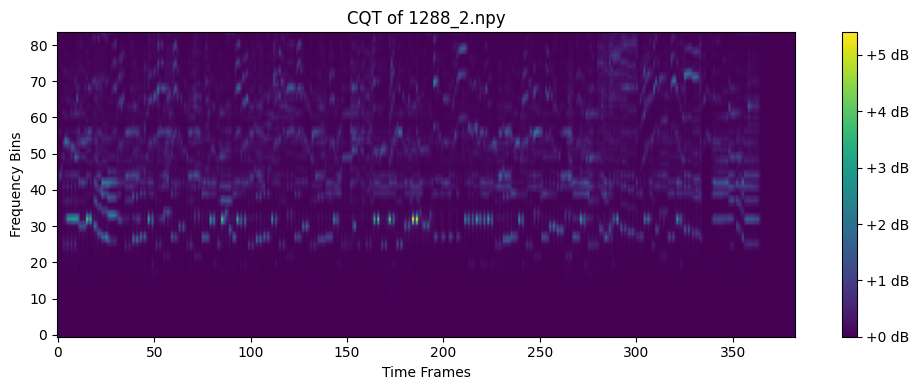

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Specify the directory containing the CQT .npy files
cqt_dir = os.path.join(DRIVE_BASE, 'youtube_cqt_npy')

# List all .npy files in the directory
npy_files = [f for f in os.listdir(cqt_dir) if f.endswith('.npy')]

if len(npy_files) > 0:
    # Select the first .npy file as an example
    example_file = npy_files[0]
    example_path = os.path.join(cqt_dir, example_file)

    try:
        # Load the CQT data
        cqt_data = np.load(example_path)

        # Plot the CQT data as a heatmap
        plt.figure(figsize=(10, 4))
        # Transpose the data for plotting (time on x-axis, frequency on y-axis)
        plt.imshow(cqt_data, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f'CQT of {example_file}')
        plt.xlabel('Time Frames')
        plt.ylabel('Frequency Bins')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error loading or plotting {example_file}: {e}")
else:
    print(f"No .npy files found in the directory: {cqt_dir}")

#CQTNet Model Impl



In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import time
import os
from collections import OrderedDict

class BasicModule(torch.nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()
        self.model_name = str(type(self).__name__) # Use __name__ to get the class name as a string

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, name=None):
        prefix = os.path.join(DRIVE_BASE, 'check_points', self.model_name) # Construct the path using os.path.join
        if not os.path.exists(prefix): # Use os.path.exists to check if the directory exists
            os.makedirs(prefix) # Use os.makedirs to create the directory and any necessary parent directories
        name = time.strftime(os.path.join(prefix, '%m%d_%H:%M:%S.pth')) # Construct the filename using os.path.join
        print('model name', os.path.basename(name) ) # Use os.path.basename to get the filename
        torch.save(self.state_dict(), name)
        torch.save(self.state_dict(), os.path.join(prefix, 'latest.pth')) # Construct the path using os.path.join
        return name

    def get_optimizer(self, lr, weight_decay):
        return torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

    def load_latest(self, notes):
        path = os.path.join(DRIVE_BASE, 'check_points', self.model_name + notes, 'latest.pth') # Construct the path using os.path.join
        self.load_state_dict(torch.load(path))

class CQTNet(BasicModule):
    def __init__(self, num_classes=5500, embedding_dim=128):
        super(CQTNet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, 16, kernel_size=(12, 3), dilation=(1, 1), padding=(6, 1), bias=False)),
            ('norm0', nn.BatchNorm2d(16)), ('relu0', nn.ReLU(inplace=True)),

            ('conv1', nn.Conv2d(16, 32, kernel_size=(13, 3), dilation=(1, 2), padding=(6, 2), bias=False)),
            ('norm1', nn.BatchNorm2d(32)), ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d((1, 2), stride=(1, 2), padding=(0, 1))),
            ('drop1', nn.Dropout2d(0.1)),

            ('conv2', nn.Conv2d(32, 64, kernel_size=(13, 3), dilation=(1, 1), padding=(6, 1), bias=False)),
            ('norm2', nn.BatchNorm2d(64)), ('relu2', nn.ReLU(inplace=True)),

            ('conv3', nn.Conv2d(64, 64, kernel_size=(3, 3), dilation=(1, 2), padding=(1, 2), bias=False)),
            ('norm3', nn.BatchNorm2d(64)), ('relu3', nn.ReLU(inplace=True)),
            ('pool3', nn.MaxPool2d((1, 2), stride=(1, 2), padding=(0, 1))),
            ('drop3', nn.Dropout2d(0.2)),

            ('conv4', nn.Conv2d(64, 128, kernel_size=(3, 3), dilation=(1, 1), padding=(1, 1), bias=False)),
            ('norm4', nn.BatchNorm2d(128)), ('relu4', nn.ReLU(inplace=True)),

            ('conv5', nn.Conv2d(128, 128, kernel_size=(3, 3), dilation=(1, 2), padding=(1, 2), bias=False)),
            ('norm5', nn.BatchNorm2d(128)), ('relu5', nn.ReLU(inplace=True)),
            ('pool5', nn.MaxPool2d((1, 2), stride=(1, 2), padding=(0, 1))),
            ('drop5', nn.Dropout2d(0.3)),
        ]))

        self.pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc0 = nn.Linear(128, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        # input [N, C, H, W] (W = 396)
        N = x.size()[0]
        x = self.features(x)  # [N, 512, 57, 2~15]
        x = self.pool(x)
        x = x.view(N, -1)
        feature = self.fc0(x)
        x = self.fc1(feature)
        return x, feature

#Hyperparameters

In [ ]:
print(f'cuda available? {torch.cuda.is_available()}')

cuda available? True


In [ ]:
import warnings

class DefaultConfig(object):

    model = 'CQTNet'
    feature = 'cqt'
    load_model_path = None
    load_latest = False
    batch_size = 32  # batch size
    use_gpu = True  # user GPU or not
    num_workers = 4  # how many workers for loading data

    max_epoch = 100
    lr = 0.0001  # initial learning rate
    lr_decay = 0.8  # when val_loss increase, lr = lr*lr_decay
    weight_decay = 1e-5
    notes = None

    def _parse(self, kwargs):
        for k, v in kwargs.items():
            if not hasattr(self, k):
                warnings.warn("Warning: opt has not attribut %s" % k)
            setattr(self, k, v)

        self.device =torch.device('cuda') if self.use_gpu else torch.device('cpu')

        print('+------------------------------------------------------+')
        print('|','user config:')
        for k, v in self.__class__.__dict__.items():
            if not k.startswith('_'):
                print('|',k, getattr(self, k))
        print('+------------------------------------------------------+')
opt = DefaultConfig()

#Train

In [ ]:
import numpy as np

def norm(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

def calc_MAP(array2d, version, que_range=None, K=1e10):
    if que_range is not None:
        que_s, que_t = que_range[0], que_range[1]
        if que_s == 0:
            ref_s, ref_t = que_t, len(array2d)
        else:
            ref_s, ref_t = 0, que_s
    else:
        que_s, que_t, ref_s, ref_t = 0, len(array2d), 0, len(array2d)

    new_array2d = []
    for u, row in enumerate(array2d[que_s: que_t]):
        row = [(v + ref_s, col) for (v, col) in enumerate(row[ref_s: ref_t]) if u + que_s != v + ref_s]
        new_array2d.append(row)
    MAP, top10, rank1 = 0, 0, 0

    for u, row in enumerate(new_array2d):
        row.sort(key=lambda x: x[1])
        per_top10, per_rank1, per_MAP = 0, 0, 0
        version_cnt = 0.
        u = u + que_s
        for k, (v, val) in enumerate(row):

            if version[u] == version[v]:

                if k < K:
                    version_cnt += 1
                    per_MAP += version_cnt / (k + 1)
                if per_rank1 == 0:
                    per_rank1 = k + 1
                if k < 10:
                    per_top10 += 1
        per_MAP /= 1 if version_cnt < 0.0001 else version_cnt
        # if per_MAP < 0.1:
        #     print row
        MAP += per_MAP
        top10 += per_top10
        rank1 += per_rank1
    return MAP / float(que_t - que_s), top10 / float(que_t - que_s) / 10, rank1 / float(que_t - que_s)

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# multi_size train
def multi_train(**kwargs):
    parallel = True
    opt.notes='CQTNet'
    opt.batch_size=32
    opt._parse(kwargs)

    model = CQTNet()
    if parallel is True:
        model = torch.nn.DataParallel(model)
    model.to(opt.device)
    print(model)
    # step2: data

    train_data0 = CQT('train', out_length=200)
    train_data1 = CQT('train', out_length=300)
    train_data2 = CQT('train', out_length=400)
    test_data = CQT('test', out_length=None)

    train_dataloader0 = DataLoader(train_data0, opt.batch_size, shuffle=True,num_workers=opt.num_workers)
    train_dataloader1 = DataLoader(train_data1, opt.batch_size, shuffle=True,num_workers=opt.num_workers)
    train_dataloader2 = DataLoader(train_data2, opt.batch_size, shuffle=True,num_workers=opt.num_workers)
    test_dataloader = DataLoader(test_data, 1, shuffle=False,num_workers=1)

    #step3: criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    lr = opt.lr
    if parallel is True:
        optimizer = torch.optim.Adam(model.module.parameters(), lr=lr, weight_decay=opt.weight_decay)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=opt.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,mode='min',factor=opt.lr_decay,patience=2, min_lr=5e-6)

    #train
    best_MAP=0
    epochs_no_improve = 0
    min_loss = float('inf')

    # Initial evaluation before training
    MAP, dis2d, labels, top10_classes_list_score, predictions = test_slow(model, test_dataloader, -1)
    top1_acc = accuracy_score(labels, predictions)
    top2_acc = topk_classes_accuracy(top10_classes_list_score, labels, k=2)
    print(f"Epoch -1: Loss: N/A, MAP: {MAP:.4f}, Top 1 Accuracy: {top1_acc:.4f}, Top 2 Accuracy: {top2_acc:.4f}, Top 10 Accuracy: {top10_classes_accuracy(top10_classes_list_score, labels):.4f}, Mean Rank 1: {rank1_mean(dis2d, labels):.2f}")

    # Print actual vs top 10 predictions for initial evaluation
    print("\nInitial Evaluation: Actual vs Top 10 Predicted Classes (based on scores):")
    for i in range(len(labels)):
        print(f"Actual class: {labels[i]}, Top 10 Predicted classes: {top10_classes_list_score[i]}")
    print("-" * 50)


    for epoch in range(opt.max_epoch): # Keep max_epoch for now, early stopping will handle the actual stopping
        model.train()
        running_loss = 0
        num = 0
        for (data0, label0),(data1, label1),(data2, label2) in tqdm(zip(train_dataloader0, train_dataloader1, train_dataloader2)):
            for flag in range(3):
                if flag==0:
                    data=data0
                    label=label0
                elif flag==1:
                    data=data1
                    label=label1
                else:
                    data=data2
                    label=label2

                # train model
                input = data.to(opt.device)
                target = label.to(opt.device)

                optimizer.zero_grad()
                score, _ = model(input)
                loss = criterion(score, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                num += target.shape[0]
        running_loss /= num
        print(f"Epoch {epoch}: Loss: {running_loss:.4f}")

        # update learning rate
        scheduler.step(running_loss)

        # validate
        MAP, dis2d, labels, top10_classes_list_score, predictions = test_slow(model, test_dataloader, epoch) # Use test_dataloader
        current_MAP = MAP
        current_top10_accuracy = top10_classes_accuracy(top10_classes_list_score, labels)
        current_rank1_mean = rank1_mean(dis2d, labels)
        current_top1_acc = accuracy_score(labels, predictions)
        current_top2_acc = topk_classes_accuracy(top10_classes_list_score, labels, k=2)


        print(f"Epoch {epoch}: MAP: {current_MAP:.4f}, Top 1 Accuracy: {current_top1_acc:.4f}, Top 2 Accuracy: {current_top2_acc:.4f}, Top 10 Accuracy: {current_top10_accuracy:.4f}, Mean Rank 1: {current_rank1_mean:.2f}")

        # Print actual vs top 10 predictions every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"\nEpoch {epoch}: Actual vs Top 10 Predicted Classes (based on scores):")
            for i in range(len(labels)):
                 print(f"Actual class: {labels[i]}, Top 10 Predicted classes: {top10_classes_list_score[i]}")
            print("-" * 50)


        if current_MAP > best_MAP:
            best_MAP = current_MAP
            print('*****************BEST MAP*****************')
            print(f"New best MAP: {best_MAP:.4f}")

        print('') # Newline for clarity

    # Final evaluation after training stops
    print("Training finished. Performing final evaluation...")
    MAP, dis2d, labels, top10_classes_list_score, predictions = test_slow(model, test_dataloader, -1) # Use -1 for final evaluation epoch
    top1_acc = accuracy_score(labels, predictions)
    top2_acc = topk_classes_accuracy(top10_classes_list_score, labels, k=2)
    print(f"Final Evaluation: MAP: {MAP:.4f}, Top 1 Accuracy: {top1_acc:.4f}, Top 2 Accuracy: {top2_acc:.4f}, Top 10 Accuracy: {top10_classes_accuracy(top10_classes_list_score, labels):.4f}, Mean Rank 1: {rank1_mean(dis2d, labels):.2f}")

    # Print actual vs top 10 predictions for final evaluation
    print("\nFinal Evaluation: Actual vs Top 10 Predicted Classes (based on scores):")
    for i in range(len(labels)):
         print(f"Actual class: {labels[i]}, Top 10 Predicted classes: {top10_classes_list_score[i]}")
    print("-" * 50)

    # Calculate and display precision, recall, f-measure
    predicted_classes = [top10[0] for top10 in top10_classes_list_score]
    precision, recall, fscore, _ = precision_recall_fscore_support(labels, predicted_classes, average='weighted')
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F-measure (weighted): {fscore:.4f}")

    # Calculate and display confusion matrix
    cm = confusion_matrix(labels, predicted_classes)
    print("Confusion Matrix:")
    # Display confusion matrix (optional: use matplotlib for better visualization)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Confusion Matrix')
    plt.show()


@torch.no_grad()
def test_slow(model, dataloader, epoch):
    model.eval()
    total, correct = 0, 0
    labels, features, predictions, scores_all = None, None, None, None # Add scores_all

    for ii, (data, label) in enumerate(dataloader):
        input = data.to(opt.device)
        score, feature = model(input)

        # Get the predicted class for Top 1 accuracy (based on score)
        _, predicted = torch.max(score.data, 1)
        predicted = predicted.cpu().numpy()

        feature = feature.data.cpu().numpy()
        label = label.data.cpu().numpy()
        score_np = score.data.cpu().numpy() # Convert score to numpy

        if features is not None:
            features = np.concatenate((features, feature), axis=0)
            labels = np.concatenate((labels,label))
            predictions = np.concatenate((predictions, predicted))
            scores_all = np.concatenate((scores_all, score_np), axis=0) # Collect scores
        else:
            features = feature
            labels = label
            predictions = predicted
            scores_all = score_np # Initialize scores_all

    features = norm(features)
    dis2d = -np.matmul(features, features.T) # [-1,1] Because normalized, so mutmul is equal to ED
    np.save('dis80.npy',dis2d)
    np.save('label80.npy',labels)

    # MAP calculation  based on embedding similarity
    MAP, top10_sample_acc, rank1_median = calc_MAP(dis2d, labels)

    # Calculate top 10 classes based on model output scores
    top10_classes_list_score = []
    for i in range(scores_all.shape[0]):
        sorted_score_indices = np.argsort(scores_all[i])[::-1][:10] # Sort descending and take top 10
        top10_classes_list_score.append(sorted_score_indices)

    model.train()
    return MAP, dis2d, labels, top10_classes_list_score, predictions # Return top10_classes_list_score

def topk_classes_accuracy(top10_classes_list, labels, k):
    """
    Calculates the percentage of samples where the actual class is in the top k predicted classes.
    Uses the already computed top 10 list (based on scores).
    """
    correct_topk = 0
    for i in range(len(labels)):
        if labels[i] in top10_classes_list[i][:k]:
            correct_topk += 1
    return correct_topk / len(labels)

def top10_classes_accuracy(top10_classes_list, labels):
    """
    Calculates the percentage of samples where the actual class is in the top 10 predicted classes.
    Uses the already computed top 10 list (based on scores).
    """
    correct_top10 = 0
    for i in range(len(labels)):
        if labels[i] in top10_classes_list[i]:
            correct_top10 += 1
    return correct_top10 / len(labels)

def rank1_mean(dis2d, labels):
    """
    Calculates the mean rank of the actual class based on dissimilarity.
    """
    ranks = []
    for i in range(len(labels)):
        # Get dissimilarities for the current sample
        dissimilarities = dis2d[i]
        # Pair dissimilarities with their corresponding labels
        labeled_dissimilarities = list(zip(dissimilarities, labels))
        # Sort based on dissimilarity
        labeled_dissimilarities.sort(key=lambda x: x[0])
        # Find the rank of the actual class
        actual_class = labels[i]
        rank = 0
        for j, (dis, label) in enumerate(labeled_dissimilarities):
            if label == actual_class:
                rank = j + 1 # Rank is 1-based
                break
        ranks.append(rank)
    return np.mean(ranks)

i changed the the way top10 classes were displayed and computed to predict classes instead of the most similar samples.

+------------------------------------------------------+
| user config:
| model CQTNet
| feature cqt
| load_model_path None
| load_latest False
| batch_size 32
| use_gpu True
| num_workers 4
| max_epoch 100
| lr 0.0001
| lr_decay 0.8
| weight_decay 1e-05
| notes CQTNet
+------------------------------------------------------+
DataParallel(
  (module): CQTNet(
    (features): Sequential(
      (conv0): Conv2d(1, 16, kernel_size=(12, 3), stride=(1, 1), padding=(6, 1), bias=False)
      (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(13, 3), stride=(1, 1), padding=(6, 2), dilation=(1, 2), bias=False)
      (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=(0, 1), dilation=1, ceil_mode=False)
      (drop1): Dropout2d(p=0.1, inplace=Fals

6it [00:09,  1.61s/it]

Epoch 0: Loss: 0.2906


Epoch 0: MAP: 0.0366, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0000, Top 10 Accuracy: 0.0000, Mean Rank 1: 1.00
*****************BEST MAP*****************
New best MAP: 0.0366



6it [00:01,  5.44it/s]

Epoch 1: Loss: 0.2447


Epoch 1: MAP: 0.0735, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0000, Top 10 Accuracy: 0.0000, Mean Rank 1: 1.00
*****************BEST MAP*****************
New best MAP: 0.0735



6it [00:01,  5.60it/s]

Epoch 2: Loss: 0.2198


Epoch 2: MAP: 0.0645, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2250, Mean Rank 1: 1.00



6it [00:01,  5.51it/s]

Epoch 3: Loss: 0.1931


Epoch 3: MAP: 0.0596, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.2750, Mean Rank 1: 1.00



6it [00:01,  5.57it/s]

Epoch 4: Loss: 0.1720


Epoch 4: MAP: 0.0776, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2500, Mean Rank 1: 1.00
*****************BEST MAP*****************
New best MAP: 0.0776



6it [00:01,  5.67it/s]

Epoch 5: Loss: 0.1551


Epoch 5: MAP: 0.0979, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0000, Top 10 Accuracy: 0.2000, Mean Rank 1: 1.00
*****************BEST MAP*****************
New best MAP: 0.0979



6it [00:01,  5.62it/s]

Epoch 6: Loss: 0.1428


Epoch 6: MAP: 0.1102, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0000, Top 10 Accuracy: 0.1750, Mean Rank 1: 1.00
*****************BEST MAP*****************
New best MAP: 0.1102



6it [00:01,  5.54it/s]

Epoch 7: Loss: 0.1355


Epoch 7: MAP: 0.1129, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2250, Mean Rank 1: 1.00
*****************BEST MAP*****************
New best MAP: 0.1129



6it [00:01,  4.90it/s]

Epoch 8: Loss: 0.1311


Epoch 8: MAP: 0.0838, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2500, Mean Rank 1: 1.00



6it [00:01,  5.36it/s]

Epoch 9: Loss: 0.1291


Epoch 9: MAP: 0.0845, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.1750, Mean Rank 1: 1.00



6it [00:01,  5.66it/s]

Epoch 10: Loss: 0.1289


Epoch 10: MAP: 0.1064, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.2000, Mean Rank 1: 1.00



6it [00:01,  5.60it/s]

Epoch 11: Loss: 0.1246


Epoch 11: MAP: 0.1202, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.2000, Mean Rank 1: 1.00
*****************BEST MAP*****************
New best MAP: 0.1202



6it [00:01,  5.55it/s]

Epoch 12: Loss: 0.1237


Epoch 12: MAP: 0.0942, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2250, Mean Rank 1: 1.00



6it [00:01,  5.57it/s]

Epoch 13: Loss: 0.1220


Epoch 13: MAP: 0.0999, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.1250, Mean Rank 1: 1.00



6it [00:01,  5.71it/s]

Epoch 14: Loss: 0.1205


Epoch 14: MAP: 0.0742, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2000, Mean Rank 1: 1.00



6it [00:01,  5.55it/s]

Epoch 15: Loss: 0.1199


Epoch 15: MAP: 0.1019, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2000, Mean Rank 1: 1.00



6it [00:01,  5.52it/s]

Epoch 16: Loss: 0.1205


Epoch 16: MAP: 0.1079, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2000, Mean Rank 1: 1.00



6it [00:01,  5.51it/s]

Epoch 17: Loss: 0.1198


Epoch 17: MAP: 0.0858, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.1500, Mean Rank 1: 1.00



6it [00:01,  5.57it/s]

Epoch 18: Loss: 0.1180


Epoch 18: MAP: 0.0759, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2250, Mean Rank 1: 1.00



6it [00:01,  5.60it/s]

Epoch 19: Loss: 0.1177


Epoch 19: MAP: 0.0864, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00

Epoch 19: Actual vs Top 10 Predicted Classes (based on scores):
Actual class: 12, Top 10 Predicted classes: [  84   19  964    9  139    1   66 1288  218    0]
Actual class: 1894, Top 10 Predicted classes: [ 227 5453   12    1 2028   19 1174 1138  240 5024]
Actual class: 218, Top 10 Predicted classes: [  84   19  139    9 1288  964  224    1    5  240]
Actual class: 240, Top 10 Predicted classes: [  19    5    1  227   84  240 1174    9 5024   12]
Actual class: 964, Top 10 Predicted classes: [  19 5453  227 1138   12 5024    1  240 3341  156]
Actual class: 2028, Top 10 Predicted classes: [  19   12  227 5024  582 3341 2028   84 1174  863]
Actual class: 4183, Top 10 Predicted classes: [  19    9    1  964 5024 2028   84 3341 1288  582]
Actual class: 345, Top 10 Predicted classes: [  19 5024  156   84  964 5453   12 2253    1    5]
Actual class: 215, Top 10 Predicted classes

6it [00:01,  5.41it/s]

Epoch 20: Loss: 0.1187


Epoch 20: MAP: 0.0715, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.54it/s]

Epoch 21: Loss: 0.1181


Epoch 21: MAP: 0.0671, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0000, Top 10 Accuracy: 0.2250, Mean Rank 1: 1.00



6it [00:01,  5.67it/s]

Epoch 22: Loss: 0.1173


Epoch 22: MAP: 0.0456, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.72it/s]

Epoch 23: Loss: 0.1157


Epoch 23: MAP: 0.0528, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.2250, Mean Rank 1: 1.00



6it [00:01,  5.53it/s]

Epoch 24: Loss: 0.1163


Epoch 24: MAP: 0.0584, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2500, Mean Rank 1: 1.00



6it [00:01,  5.52it/s]

Epoch 25: Loss: 0.1153


Epoch 25: MAP: 0.0712, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2250, Mean Rank 1: 1.00



6it [00:01,  5.60it/s]

Epoch 26: Loss: 0.1150


Epoch 26: MAP: 0.0815, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.61it/s]

Epoch 27: Loss: 0.1140


Epoch 27: MAP: 0.0701, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.43it/s]

Epoch 28: Loss: 0.1119


Epoch 28: MAP: 0.0638, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.2750, Mean Rank 1: 1.00



6it [00:01,  5.45it/s]

Epoch 29: Loss: 0.1134


Epoch 29: MAP: 0.0627, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.2250, Mean Rank 1: 1.00



6it [00:01,  5.52it/s]

Epoch 30: Loss: 0.1144


Epoch 30: MAP: 0.0946, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.71it/s]

Epoch 31: Loss: 0.1129


Epoch 31: MAP: 0.0818, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.2750, Mean Rank 1: 1.00



6it [00:01,  5.33it/s]

Epoch 32: Loss: 0.1125


Epoch 32: MAP: 0.0635, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.1000, Top 10 Accuracy: 0.2750, Mean Rank 1: 1.00



6it [00:01,  5.51it/s]

Epoch 33: Loss: 0.1114


Epoch 33: MAP: 0.0856, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.2750, Mean Rank 1: 1.00



6it [00:01,  5.55it/s]

Epoch 34: Loss: 0.1123


Epoch 34: MAP: 0.0900, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.58it/s]

Epoch 35: Loss: 0.1119


Epoch 35: MAP: 0.0792, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.2500, Mean Rank 1: 1.00



6it [00:01,  5.76it/s]

Epoch 36: Loss: 0.1082


Epoch 36: MAP: 0.0724, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.2750, Mean Rank 1: 1.00



6it [00:01,  5.45it/s]

Epoch 37: Loss: 0.1113


Epoch 37: MAP: 0.0798, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.38it/s]

Epoch 38: Loss: 0.1095


Epoch 38: MAP: 0.0800, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.51it/s]

Epoch 39: Loss: 0.1095


Epoch 39: MAP: 0.0703, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.1000, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00

Epoch 39: Actual vs Top 10 Predicted Classes (based on scores):
Actual class: 12, Top 10 Predicted classes: [  84    9   19  964  139    1  218 1288   66    0]
Actual class: 1894, Top 10 Predicted classes: [ 227    1  159 5453 2028 1138 1174    5  240 5024]
Actual class: 218, Top 10 Predicted classes: [ 139    9   84  964 1288  224  863   19    5    1]
Actual class: 240, Top 10 Predicted classes: [   5  159  139   84  596 2253  240   66 1174  863]
Actual class: 964, Top 10 Predicted classes: [  19  345  863  159    5 1138  582  224 1174 5024]
Actual class: 2028, Top 10 Predicted classes: [  19 2028 1174  227    5  159 5024  293  390   84]
Actual class: 4183, Top 10 Predicted classes: [  19    9    1  964   84  218 3341    0  345  582]
Actual class: 345, Top 10 Predicted classes: [964 139   5  84  66   9 156 159 863  19]
Actual class: 215, Top 10 Predicted classes: [2028   

6it [00:01,  5.49it/s]

Epoch 40: Loss: 0.1106


Epoch 40: MAP: 0.0696, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.39it/s]

Epoch 41: Loss: 0.1091


Epoch 41: MAP: 0.0685, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.69it/s]

Epoch 42: Loss: 0.1094


Epoch 42: MAP: 0.0623, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.75it/s]

Epoch 43: Loss: 0.1093


Epoch 43: MAP: 0.0588, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.70it/s]

Epoch 44: Loss: 0.1092


Epoch 44: MAP: 0.0686, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.39it/s]

Epoch 45: Loss: 0.1091


Epoch 45: MAP: 0.0681, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.71it/s]

Epoch 46: Loss: 0.1087


Epoch 46: MAP: 0.0856, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.56it/s]

Epoch 47: Loss: 0.1081


Epoch 47: MAP: 0.0791, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.51it/s]

Epoch 48: Loss: 0.1072


Epoch 48: MAP: 0.0842, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.54it/s]

Epoch 49: Loss: 0.1082


Epoch 49: MAP: 0.0973, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.63it/s]

Epoch 50: Loss: 0.1071


Epoch 50: MAP: 0.0881, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.48it/s]

Epoch 51: Loss: 0.1072


Epoch 51: MAP: 0.0807, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.60it/s]

Epoch 52: Loss: 0.1081


Epoch 52: MAP: 0.0857, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.68it/s]

Epoch 53: Loss: 0.1093


Epoch 53: MAP: 0.0784, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3000, Mean Rank 1: 1.00



6it [00:01,  5.49it/s]

Epoch 54: Loss: 0.1078


Epoch 54: MAP: 0.0870, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.50it/s]

Epoch 55: Loss: 0.1050


Epoch 55: MAP: 0.0880, Top 1 Accuracy: 0.0000, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.40it/s]

Epoch 56: Loss: 0.1062


Epoch 56: MAP: 0.1022, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.2750, Mean Rank 1: 1.00



6it [00:01,  5.48it/s]

Epoch 57: Loss: 0.1065


Epoch 57: MAP: 0.0950, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.70it/s]

Epoch 58: Loss: 0.1083


Epoch 58: MAP: 0.0877, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.60it/s]

Epoch 59: Loss: 0.1056


Epoch 59: MAP: 0.0864, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00

Epoch 59: Actual vs Top 10 Predicted Classes (based on scores):
Actual class: 12, Top 10 Predicted classes: [  84    9 1288  964   19  218  139    0   66  863]
Actual class: 1894, Top 10 Predicted classes: [ 227    1 5453  159 1138 2028 1174 2253    5  240]
Actual class: 218, Top 10 Predicted classes: [1288  964    9  139   84  863  224  240   19  345]
Actual class: 240, Top 10 Predicted classes: [2253 1288 1174  159  240    5  139   84  345 2028]
Actual class: 964, Top 10 Predicted classes: [  19 1138 1174  345  582  159 3341  863 1288  224]
Actual class: 2028, Top 10 Predicted classes: [2028 1174  227   19  294  582  293 5024 2253  390]
Actual class: 4183, Top 10 Predicted classes: [  19    9 1288  218  582  964  345 3341   66 1174]
Actual class: 345, Top 10 Predicted classes: [964 139  84 156   5 863 209 345  66   9]
Actual class: 215, Top 10 Predicted classes: [1174 20

6it [00:01,  5.61it/s]

Epoch 60: Loss: 0.1048


Epoch 60: MAP: 0.0811, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.1000, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.59it/s]

Epoch 61: Loss: 0.1059


Epoch 61: MAP: 0.0993, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.4000, Mean Rank 1: 1.00



6it [00:01,  5.78it/s]

Epoch 62: Loss: 0.1055


Epoch 62: MAP: 0.0935, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.1000, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.54it/s]

Epoch 63: Loss: 0.1050


Epoch 63: MAP: 0.0960, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00



6it [00:01,  5.36it/s]

Epoch 64: Loss: 0.1056


Epoch 64: MAP: 0.0958, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0250, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.65it/s]

Epoch 65: Loss: 0.1053


Epoch 65: MAP: 0.0950, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.71it/s]

Epoch 66: Loss: 0.1048


Epoch 66: MAP: 0.0950, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.61it/s]

Epoch 67: Loss: 0.1048


Epoch 67: MAP: 0.1206, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3250, Mean Rank 1: 1.00
*****************BEST MAP*****************
New best MAP: 0.1206



6it [00:01,  5.61it/s]

Epoch 68: Loss: 0.1060


Epoch 68: MAP: 0.0955, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.72it/s]

Epoch 69: Loss: 0.1040


Epoch 69: MAP: 0.1070, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.59it/s]

Epoch 70: Loss: 0.1045


Epoch 70: MAP: 0.0915, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.50it/s]

Epoch 71: Loss: 0.1066


Epoch 71: MAP: 0.1044, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.37it/s]

Epoch 72: Loss: 0.1029


Epoch 72: MAP: 0.0884, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.1250, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.51it/s]

Epoch 73: Loss: 0.1047


Epoch 73: MAP: 0.1047, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.41it/s]

Epoch 74: Loss: 0.1036


Epoch 74: MAP: 0.1034, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.58it/s]

Epoch 75: Loss: 0.1067


Epoch 75: MAP: 0.1170, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.60it/s]

Epoch 76: Loss: 0.1033


Epoch 76: MAP: 0.1170, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.4250, Mean Rank 1: 1.00



6it [00:01,  5.63it/s]

Epoch 77: Loss: 0.1026


Epoch 77: MAP: 0.1069, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.4000, Mean Rank 1: 1.00



6it [00:01,  5.60it/s]

Epoch 78: Loss: 0.1034


Epoch 78: MAP: 0.1052, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.4000, Mean Rank 1: 1.00



6it [00:01,  5.46it/s]

Epoch 79: Loss: 0.1032


Epoch 79: MAP: 0.1047, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.4000, Mean Rank 1: 1.00

Epoch 79: Actual vs Top 10 Predicted Classes (based on scores):
Actual class: 12, Top 10 Predicted classes: [   9   84  964   19 1288   66  218    0  139  863]
Actual class: 1894, Top 10 Predicted classes: [ 227    1 5453 2253  159 1138 2028    5  240   44]
Actual class: 218, Top 10 Predicted classes: [ 964    9 1288  224   84  139  863   19  240    5]
Actual class: 240, Top 10 Predicted classes: [2253  159    5 1174  240 1288   84 2028  596  293]
Actual class: 964, Top 10 Predicted classes: [  19  345 1138  159 1174  215  224  582 1288 3341]
Actual class: 2028, Top 10 Predicted classes: [2028  227   19 1174  293 2253  390  345  159    5]
Actual class: 4183, Top 10 Predicted classes: [  19    9  964   66  345 1288 3341   84    1  218]
Actual class: 345, Top 10 Predicted classes: [964 139   5 156  84 209  66 345 240   9]
Actual class: 215, Top 10 Predicted classes: [1174 20

6it [00:01,  5.56it/s]

Epoch 80: Loss: 0.1037


Epoch 80: MAP: 0.1065, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.70it/s]

Epoch 81: Loss: 0.1051


Epoch 81: MAP: 0.1060, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.66it/s]

Epoch 82: Loss: 0.1030


Epoch 82: MAP: 0.1195, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.4000, Mean Rank 1: 1.00



6it [00:01,  5.53it/s]

Epoch 83: Loss: 0.1027


Epoch 83: MAP: 0.1043, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.62it/s]

Epoch 84: Loss: 0.1045


Epoch 84: MAP: 0.1066, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.62it/s]

Epoch 85: Loss: 0.1049


Epoch 85: MAP: 0.1036, Top 1 Accuracy: 0.0250, Top 2 Accuracy: 0.0500, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.54it/s]

Epoch 86: Loss: 0.1019


Epoch 86: MAP: 0.1029, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.50it/s]

Epoch 87: Loss: 0.1036


Epoch 87: MAP: 0.1027, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.50it/s]

Epoch 88: Loss: 0.1042


Epoch 88: MAP: 0.1156, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.4000, Mean Rank 1: 1.00



6it [00:01,  5.46it/s]

Epoch 89: Loss: 0.1038


Epoch 89: MAP: 0.1169, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.69it/s]

Epoch 90: Loss: 0.1042


Epoch 90: MAP: 0.1171, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.46it/s]

Epoch 91: Loss: 0.1053


Epoch 91: MAP: 0.1029, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.1000, Top 10 Accuracy: 0.4000, Mean Rank 1: 1.00



6it [00:01,  5.62it/s]

Epoch 92: Loss: 0.1027


Epoch 92: MAP: 0.1151, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.46it/s]

Epoch 93: Loss: 0.1047


Epoch 93: MAP: 0.1059, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.4000, Mean Rank 1: 1.00



6it [00:01,  5.62it/s]

Epoch 94: Loss: 0.1037


Epoch 94: MAP: 0.1056, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.4250, Mean Rank 1: 1.00



6it [00:01,  5.49it/s]

Epoch 95: Loss: 0.1011


Epoch 95: MAP: 0.1056, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.61it/s]

Epoch 96: Loss: 0.1036


Epoch 96: MAP: 0.1059, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.64it/s]

Epoch 97: Loss: 0.1032


Epoch 97: MAP: 0.1187, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3500, Mean Rank 1: 1.00



6it [00:01,  5.75it/s]

Epoch 98: Loss: 0.1025


Epoch 98: MAP: 0.1189, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.1000, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00



6it [00:01,  5.62it/s]

Epoch 99: Loss: 0.1025


Epoch 99: MAP: 0.1187, Top 1 Accuracy: 0.0500, Top 2 Accuracy: 0.0750, Top 10 Accuracy: 0.3750, Mean Rank 1: 1.00

Epoch 99: Actual vs Top 10 Predicted Classes (based on scores):
Actual class: 12, Top 10 Predicted classes: [   9   84   19  964 1288   66  139  218    0  863]
Actual class: 1894, Top 10 Predicted classes: [   1  227 5453  159 1138 2253 2028   44    5  240]
Actual class: 218, Top 10 Predicted classes: [1288  964    9  139  224   84  863   19    5  240]
Actual class: 240, Top 10 Predicted classes: [ 159 2253  240    5 1174  139 1288   84  293  596]
Actual class: 964, Top 10 Predicted classes: [  19 1138  345  159 1174  224  215  863  582 3341]
Actual class: 2028, Top 10 Predicted classes: [2028  227 1174 2253   19  293  390  345  159    5]
Actual class: 4183, Top 10 Predicted classes: [  19    9   66  964  345    1 3341    0  218  582]
Actual class: 345, Top 10 Predicted classes: [139 964 156   5  84 209  66 345 863   9]
Actual class: 215, Top 10 Predicted classes: [1174 20

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


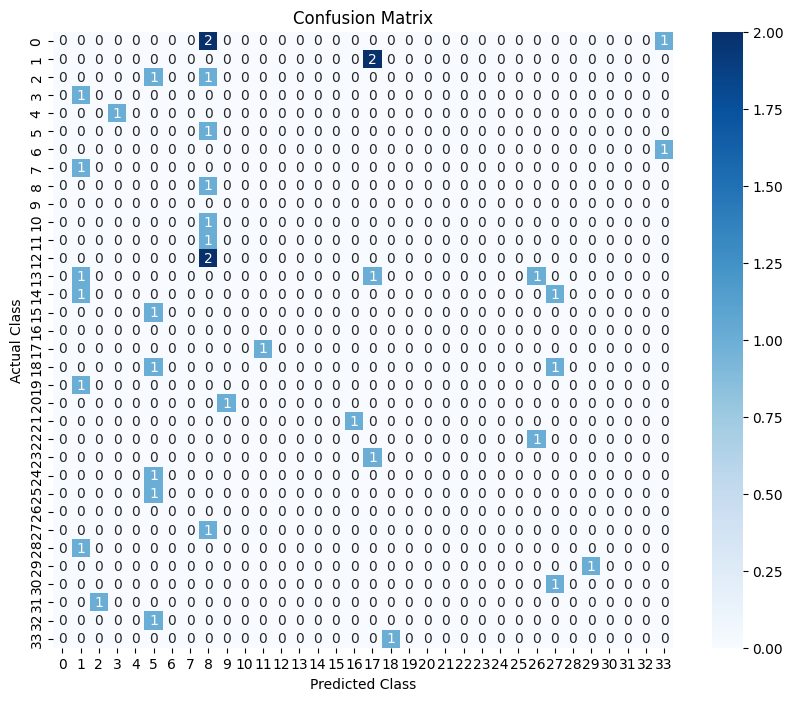

In [ ]:
multi_train()